<a href="https://colab.research.google.com/github/etuckerman/LTSM_Crypto_Prediction/blob/main/LSTM_Crypto_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
50/50 [==============================] - 12s 38ms/step - loss: 0.1840 - val_loss: 0.0751
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0969 - val_loss: 0.0750
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0898 - val_loss: 0.0779
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0860 - val_loss: 0.0755
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0839 - val_loss: 0.0759
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0834 - val_loss: 0.0755
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0833 - val_loss: 0.0766
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0842 - val_loss: 0.0753
Epoch 9/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0838 - val_loss: 0.0752
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0837 - val_loss: 0.0757
Epoch 11/50
50/50

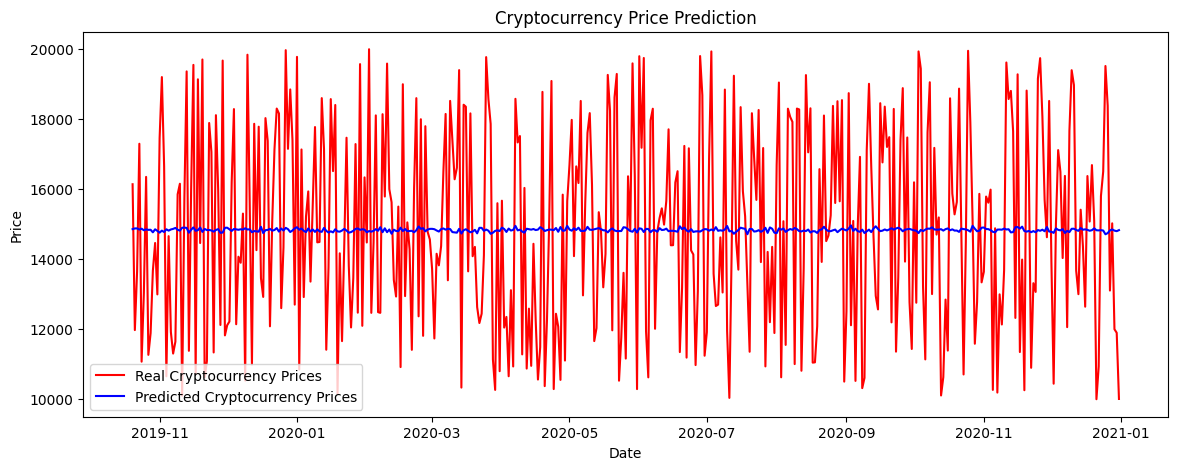

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Generate sample data
np.random.seed(0)
dates = pd.date_range(start='2015-01-01', end='2020-12-31', freq='D')
n = len(dates)

opening_prices = np.cumsum(np.random.randn(n)) + 100
data = pd.DataFrame({
    'date': dates,
    'opening_price': opening_prices,
    'highest_price': opening_prices + np.random.randn(n) * 5,
    'lowest_price': opening_prices - np.random.randn(n) * 5,
    'closing_price': opening_prices + np.random.randn(n),
    'trading_volume': np.random.randint(10000, 20000, n)
})

# Prepare data
num_features = len(data.columns) - 2
dataset = data.drop(columns=['date']).to_numpy()

train_size = int(0.8 * n)
train_data, test_data = dataset[:train_size, :], dataset[train_size:, :]

scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

train_input = scaler_input.fit_transform(train_data[:, :-1])
train_output = scaler_output.fit_transform(train_data[:, -1].reshape(-1, 1))

test_input = scaler_input.transform(test_data[:, :-1])
test_output = scaler_output.transform(test_data[:, -1].reshape(-1, 1))

train_input = np.reshape(train_input, (train_input.shape[0], 1, num_features))
test_input = np.reshape(test_input, (test_input.shape[0], 1, num_features))

# Define model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_input.shape[1], num_features)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model
model.fit(train_input, train_output, epochs=50, batch_size=32, validation_split=0.1)

# Make predictions
test_predictions = model.predict(test_input)
test_predictions = scaler_output.inverse_transform(test_predictions)

# Calculate mean absolute error
test_output = scaler_output.inverse_transform(test_output)
mae = np.mean(np.abs(test_predictions - test_output))
print(f"Test MAE: {mae:.2f}")

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(data['date'][train_size:], test_output, color='red', label='Real Cryptocurrency Prices')
plt.plot(data['date'][train_size:], test_predictions, color='blue', label='Predicted Cryptocurrency Prices')
plt.title('Cryptocurrency Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()